In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy import stats
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn as sk
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import keras
import tensorflow as tf
import yfinance as yf
import seaborn as sn
import pandas_datareader.data as reader

In [215]:
#Get Data
ticker = str(input('Please input ticker'))
equity_data = yf.download(ticker, start =  '2005-01-01', end = '2020-09-01', interval = '1d', auto_adjust = 'True')
print(equity_data.columns)
equity_data['Pct_Returns']= equity_data["Close"].pct_change(1)
equity_data['Pct_Returns']`
equity_data['Raw_Returns'] = equity_data['Pct_Returns']*100
equity_data['Log_Returns'] = np.log(equity_data.Close) - np.log(equity_data.Close.shift(1))
equity_data.tail()


Please input tickerGOOGL
[*********************100%***********************]  1 of 1 completed
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


,Open,High,Low,Close,Volume,Pct_Returns,Raw_Returns,Log_Returns
Date,,,,,,,,
2020-08-25,1580.099976,1608.880005,1577.880005,1605.849976,1257500,0.013059,1.305867,0.012974
2020-08-26,1606.300049,1652.790039,1600.979980,1644.130005,2609400,0.023838,2.383786,0.023558
2020-08-27,1646.609985,1647.989990,1618.810059,1628.520020,1567500,-0.009494,-0.949437,-0.009540
2020-08-28,1629.469971,1641.349976,1625.609985,1639.430054,1120900,0.006699,0.669936,0.006677
2020-08-31,1643.569946,1644.500000,1625.329956,1629.530029,1321100,-0.006039,-0.603870,-0.006057


In [216]:
factors = reader.DataReader('F-F_Research_Data_Factors','famafrench',start =  '2005-01-01', end = '2020-08-31')
factors = factors[0]
equity_returns_mt = equity_data['Pct_Returns'].resample('M').agg(lambda x:(x+1).prod()-1)
#equity_returns_mt = equity_returns_mt[:-1]
equity_returns_mt.index = factors.index
print(factors.head())
print(equity_returns_mt.head())
print(factors.shape)
print(equity_returns_mt.shape)
full_dataset = pd.merge(factors,equity_returns_mt,on = 'Date')
full_dataset[['Mkt-RF','SMB','HML','RF']]= full_dataset[['Mkt-RF','SMB','HML','RF']]/100 #coverting from percent to raw value 
full_dataset['Excess_Returns']=full_dataset['Pct_Returns'] - full_dataset['RF'] #Excess Return = Portfolio - RF
full_dataset=full_dataset.rename(columns = {'Pct_Returns':ticker + ' Pct_Returns'})
full_dataset.shape

         Mkt-RF   SMB   HML    RF
Date                             
2005-01   -2.76 -1.72  2.01  0.16
2005-02    1.89 -0.55  1.63  0.16
2005-03   -1.97 -1.35  2.14  0.21
2005-04   -2.61 -3.97  0.05  0.21
2005-05    3.65  2.80 -0.66  0.24
Date
2005-01   -0.034976
2005-02   -0.039004
2005-03   -0.039789
2005-04    0.218769
2005-05    0.260318
Freq: M, Name: Pct_Returns, dtype: float64
(188, 4)
(188,)


(188, 6)

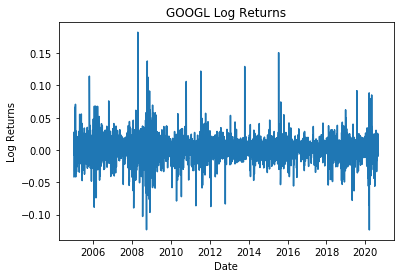

In [217]:
#closing price
plt.title(str(ticker) +' Log Returns')
plt.plot(equity_data['Log_Returns'])
plt.xlabel('Date')
plt.ylabel("Log Returns")
plt.show()

In [218]:
full_dataset.shape
full_dataset

,Mkt-RF,SMB,HML,RF,GOOGL Pct_Returns,Excess_Returns
Date,,,,,,
2005-01,-0.0276,-0.0172,0.0201,0.0016,-0.034976,-0.036576
2005-02,0.0189,-0.0055,0.0163,0.0016,-0.039004,-0.040604
2005-03,-0.0197,-0.0135,0.0214,0.0021,-0.039789,-0.041889
2005-04,-0.0261,-0.0397,0.0005,0.0021,0.218769,0.216669
2005-05,0.0365,0.0280,-0.0066,0.0024,0.260318,0.257918
...,...,...,...,...,...,...
2020-04,0.1365,0.0275,-0.0139,0.0000,0.159000,0.159000
2020-05,0.0558,0.0249,-0.0505,0.0001,0.064469,0.064369
2020-06,0.0246,0.0271,-0.0235,0.0001,-0.010792,-0.010892


In [233]:
#amount of data to train,
forecast = 12
training_close_length = (len(full_dataset)- 12)/len(full_dataset)
#training_close_length
print((math.ceil((1/20)*len(full_dataset))))

10


In [232]:
y_values = full_dataset["Excess_Returns"]
x_values = full_dataset.iloc[:,0:3]
x_train,x_test,y_train,y_test = train_test_split(x_values, y_values, test_size = (math.ceil((1/20)*len(full_dataset))),
                                                 shuffle = False,
                                                 )
x_train.iloc[:len(x_train),:]
(x_train)

,Mkt-RF,SMB,HML
Date,,,
2005-01,-0.0276,-0.0172,0.0201
2005-02,0.0189,-0.0055,0.0163
2005-03,-0.0197,-0.0135,0.0214
2005-04,-0.0261,-0.0397,0.0005
2005-05,0.0365,0.0280,-0.0066
...,...,...,...
2019-06,0.0693,0.0022,-0.0079
2019-07,0.0119,-0.0208,0.0034
2019-08,-0.0258,-0.0240,-0.0485


In [221]:
#Scaling
sc = MinMaxScaler((-1,1))
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_train, x_test = np.array(x_train), np.array(x_test)

In [222]:
y_train,y_test = np.array(y_train).reshape(-1,1), np.array(y_test).reshape(-1,1)
y_train = sc.fit_transform(y_train)
y_test = sc.fit_transform(y_test)
len(y_train)

178

In [208]:
#MODEl 
def define_model(lr=.01,
                 nodes_2=64,
                 nodes_3=36,
                 drop_rate_1 = .3,
                 drop_rate_2 = .3,
                 activation_2='sigmoid', activation_3='sigmoid'):
    model = Sequential ()
    #model.add(Dense(nodes_1,input_dim = 3,
    #              activation = activation_1,)),
    #model.add(Dropout(.3)),
    model.add(Dense(nodes_2,
                    input_dim = 3,
                   activation = activation_2)),
    model.add(Dropout(rate=drop_rate_1)),
    model.add(Dense(nodes_3,
                    #input_dim = 3,
                   activation = activation_3)),
    model.add(Dropout(rate=drop_rate_2)),
    model.add(Dense(1,
             activation = "linear")) #Dense --> Default activation is linear
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss = 'mean_squared_error',
                  metrics =['mse']) #metrics =[tf.keras.metrics.AUC()]
    return model 

In [165]:
model = define_model(lr = .0001,
                     nodes_2 = 64,
                     nodes_3 = 36
                     activation_2='tanh',
                     activation_3='sigmoid',
                     drop_rate_1 = .3,
                     drop_rate_2 = .3)
model.summary()

SyntaxError: invalid syntax (<ipython-input-165-76fddfe71e52>, line 6)

In [74]:
model_tuning = KerasRegressor(build_fn = define_model,
                              #epochs=80,batch_size=64,
                              lr = .0001,
                              #nodes_1 = 64, 
                              #nodes_2=24, 
                              #nodes_3=8,
                              #activation_1='tanh',
                              #activation_2='sigmoid', 
                              #activation_3='sigmoid',
                              drop_rate_1 =.2,
                              drop_rate_2 = .2)

In [75]:
#HyperParameter Optimization
lr = [.001,.005,.0001]
#units = [[25,30],[15,10]]
#optimizer = ['SGD','ADAM']
#batch_size = [64]
#epochs=[80]
#n_nodes_1 = [64]
#n_nodes_2 = [32,24]
#n_nodes_3 = [16,8]
#activation_1 = ['sigmoid','tanh'] 
#activation_2 = ['sigmoid','tanh']
#activation_3 = ['sigmoid','tanh']
drop_rate_1 = [.2,.3,.4]
drop_rate_2 = [.2,.3,.4]
param_grid = dict(#optimizer = optimizer,
                  #batch_size= batch_size,
                  #epochs=epochs,
                  drop_rate_1 = drop_rate_1,
                  drop_rate_2 = drop_rate_2,
                  lr = lr
                  #nodes_1 = n_nodes_1,
                  #nodes_2= n_nodes_2,
                  #nodes_3 = n_nodes_3,
                  #activation_1 = activation_1,
                  #activation_2 = activation_2,
                  #activation_3 = activation_3
                 )
grid = GridSearchCV(estimator = model_tuning,param_grid = param_grid)
grid_result = grid.fit(x_train,y_train)

5/5 [==============================] - 0s 799us/step - loss: 0.4336 - mse: 0.4336


KeyboardInterrupt: 

In [319]:
results = pd.DataFrame(grid_result.cv_results_)
results.to_csv('FF_Dense_HyperTuning')
print("Best: %s" % (grid_result.best_params_))
results;

Best: {'activation_2': 'tanh', 'activation_3': 'sigmoid'}


In [209]:
EPOCHS = 130 #HOW MANY TIMES IS THE DATA FED THROUGH THE SYSTEM
BATCH_SIZE = 64  #HOW MUCH OF THE TRAINING DATA IS PUT THROUGH BEFORE WEIGHT UPDATES
VALIDATION_SPLIT = .2 #HOW MUCH OF THE TRAINING SET IS SET ASIDE TO VALIDATE
call_backs = [
    tf.keras.callbacks.CSVLogger('FF_Dense.log',
                                 separator = ',',
                                 append = False), #Export performance to CSV
    tf.keras.callbacks.EarlyStopping(monitor = 'mse',
                                     patience = 30, 
                                     restore_best_weights = True )]

model.fit(x_train, y_train,batch_size= BATCH_SIZE,
          epochs =EPOCHS,
          callbacks = call_backs,
          validation_split= VALIDATION_SPLIT)


Epoch 1/130
3/3 [==============================] - 0s 13ms/step - loss: 0.0935 - mse: 0.0935 - val_loss: 0.0561 - val_mse: 0.0561
Epoch 2/130
3/3 [==============================] - 0s 6ms/step - loss: 0.0742 - mse: 0.0742 - val_loss: 0.0553 - val_mse: 0.0553
Epoch 3/130
3/3 [==============================] - 0s 6ms/step - loss: 0.0711 - mse: 0.0711 - val_loss: 0.0549 - val_mse: 0.0549
Epoch 4/130
3/3 [==============================] - 0s 5ms/step - loss: 0.0758 - mse: 0.0758 - val_loss: 0.0548 - val_mse: 0.0548
Epoch 5/130
3/3 [==============================] - 0s 5ms/step - loss: 0.0808 - mse: 0.0808 - val_loss: 0.0549 - val_mse: 0.0549
Epoch 6/130
3/3 [==============================] - 0s 6ms/step - loss: 0.0793 - mse: 0.0793 - val_loss: 0.0551 - val_mse: 0.0551
Epoch 7/130
3/3 [==============================] - 0s 6ms/step - loss: 0.0759 - mse: 0.0759 - val_loss: 0.0552 - val_mse: 0.0552
Epoch 8/130
3/3 [==============================] - 0s 5ms/step - loss: 0.0761 - mse: 0.0761 - va

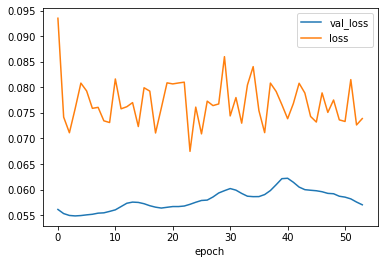

In [210]:
train_log = pd.read_csv('FF_Dense.log',index_col = 'epoch')
train_log.val_loss.plot(legend=True)
train_log.loss.plot(legend=True)#val_loss vs epoch

In [211]:
model.save('AAPL_Dense_MODEL')

INFO:tensorflow:Assets written to: AAPL_Dense_MODEL\assets


In [341]:
#PREDICTION
import_model = load_model('Citi_Dense_MODEL') #load model
train_prediction_unscaled = import_model.predict(x_train)
test_prediction_unscaled = import_model.predict(x_test)
train_prediction_unscaledtrain_prediction = sc.inverse_transform(train_prediction_unscaled) #PREDICTIONS USING TRAIN DATA
test_prediction = sc.inverse_transform(test_prediction_unscaled) #PREDICTIONS USING TEST DATA
test_prediction
Citi_Predictions_Train = pd.DataFrame(train_prediction)
Citi_Predictions_Test = pd.DataFrame(test_prediction)
Citi_Predictions_Test.columns,Citi_Predictions_Train.columns = ['Citi_Predictions'], ['Citi_Predictions']
#Citi_Predictions_Test.to_csv("Citi_Predictions_Test")
#Citi_Predictions_Train.to_csv("Citi_Prediction_Train")

In [ ]:
#RMSE
#rmse_test = np.sqrt(np.mean(test_prediction - y_test)**2)
rmse_train = np.sqrt(np.mean(train_prediction - y_train)**2)
print(('RMSE for the Test set is ') + str(rmse_test))
print(('RMSE for the Train set is ') + str(rmse_train))

In [223]:
#Googl_to_CSV
import_model = load_model('AAPL_Dense_MODEL') #load model
train_prediction_unscaled = import_model.predict(x_train)
test_prediction_unscaled = import_model.predict(x_test)
train_prediction = sc.inverse_transform(train_prediction_unscaled) #PREDICTIONS USING TRAIN DATA
test_prediction = sc.inverse_transform(test_prediction_unscaled) #PREDICTIONS USING TEST DATA
GOOGL_Predictions_Train = pd.DataFrame(train_prediction)
GOOGL_Predictions_Test = pd.DataFrame(test_prediction)
GOOGL_Predictions_Test.columns,GOOGL_Predictions_Train.columns = ['GOOGL_Predictions'], ['GOOGL_Predictions']
GOOGL_Predictions_Test.to_csv("GOOGL_Predictions_Test")
GOOGL_Predictions_Train.to_csv("GOOGL_Prediction_Train")
test_prediction

array([[ 0.02183362],
       [-0.03639443],
       [ 0.04101453],
       [-0.03814105],
       [ 0.00783385],
       [ 0.09978767],
       [ 0.06315739],
       [-0.0040299 ],
       [ 0.06802178],
       [ 0.07770608]], dtype=float32)

In [214]:
#AAPL_to_CSV
import_model = load_model('AAPL_Dense_MODEL') #load model
train_prediction_unscaled = import_model.predict(x_train)
test_prediction_unscaled = import_model.predict(x_test)
train_prediction = sc.inverse_transform(train_prediction_unscaled) #PREDICTIONS USING TRAIN DATA
test_prediction = sc.inverse_transform(test_prediction_unscaled) #PREDICTIONS USING TEST DATA
AAPL_Predictions_Train = pd.DataFrame(train_prediction)
AAPL_Predictions_Test = pd.DataFrame(test_prediction)
AAPL_Predictions_Test.columns,AAPL_Predictions_Train.columns = ['AAPL_Predictions'], ['AAPL_Predictions']
AAPL_Predictions_Test.to_csv("AAPL_Predictions_Test")
AAPL_Predictions_Train.to_csv("AAPL_Prediction_Train")
test_prediction

array([[ 0.06065244],
       [-0.00549289],
       [ 0.08244138],
       [-0.00747699],
       [ 0.04474912],
       [ 0.14920594],
       [ 0.10759503],
       [ 0.03127226],
       [ 0.11312082],
       [ 0.12412191]], dtype=float32)

In [176]:
#COKE_to_CSV
import_model = load_model('Citi_Dense_MODEL') #load model
train_prediction_unscaled = import_model.predict(x_train)
test_prediction_unscaled = import_model.predict(x_test)
train_prediction = sc.inverse_transform(train_prediction_unscaled) #PREDICTIONS USING TRAIN DATA
test_prediction = sc.inverse_transform(test_prediction_unscaled) #PREDICTIONS USING TEST DATA
Coke_Predictions_Train = pd.DataFrame(train_prediction)
Coke_Predictions_Test = pd.DataFrame(test_prediction)
Coke_Predictions_Test.columns,Coke_Predictions_Train.columns = ['Coke_Predictions'], ['Coke_Predictions']
Coke_Predictions_Test.to_csv("Coke_Predictions_Test")
Coke_Predictions_Train.to_csv("Coke_Prediction_Train")

In [ ]:
#Tesla_to_CSV
import_model = load_model('Citi_Dense_MODEL') #load model
train_prediction_unscaled = import_model.predict(x_train)
test_prediction_unscaled = import_model.predict(x_test)
test_prediction_unscaled
Tesla_predictions = pd.DataFrame(test_prediction,prediction_time_interval)
Tesla_predictions.columns = ['Citi_Estimates']
Tesla_predictions.to_csv("Tesla_Prediction_01-01-2020_onwards")
Tesla_predictions.plot()
Tesla_predictions.describe